<a href="https://colab.research.google.com/github/Ajitnag/ACMIITGN/blob/main/ACM_SS_Image_stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Stitching

In [ ]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import imageio

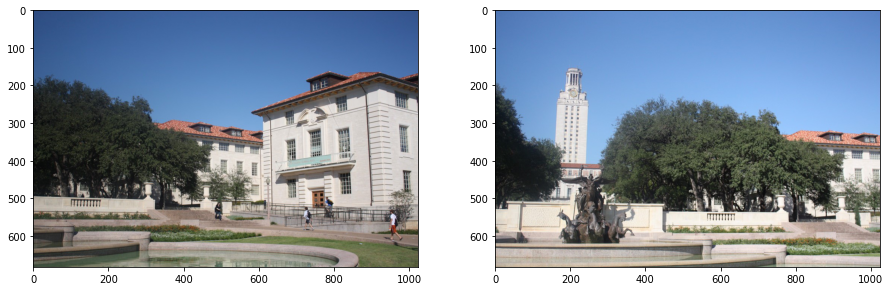

In [ ]:
def plot_img(img, size=(7,7), title=""):
    cmap = "gray" if len(img.shape) == 2 else None
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=5, size=7, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        cmap="gray" if len(img.shape) == 2 else None
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()



src_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
tar_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')

src_gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
tar_gray = cv2.cvtColor(tar_img, cv2.COLOR_RGB2GRAY)

plot_imgs([src_img, tar_img], size=8)


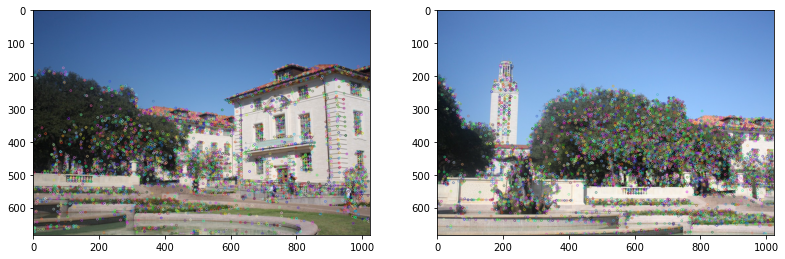

In [ ]:
SIFT_detector = cv2.xfeatures2d.SIFT_create()
kp1, des1 = SIFT_detector.detectAndCompute(src_gray, None)
kp2, des2 = SIFT_detector.detectAndCompute(tar_gray, None)

plot_imgs([
    cv2.drawKeypoints(src_img, kp1, None),
    cv2.drawKeypoints(tar_img, kp2, None)
])


## Match keypoint

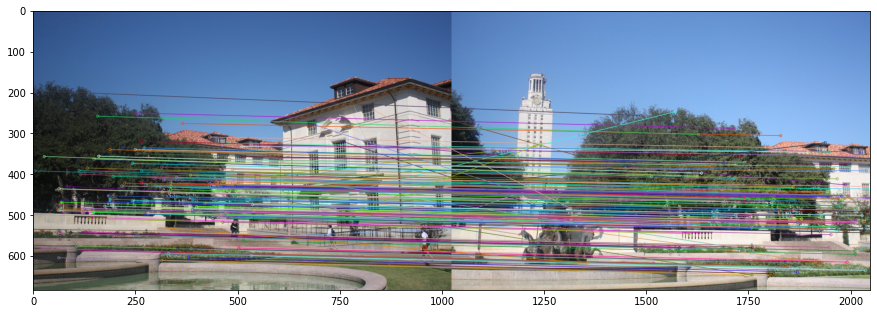

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

## Brute Force KNN 
rawMatches = bf.knnMatch(des1, des2, 2)
matches = []
ratio = 0.75

for m,n in rawMatches:
    if m.distance < n.distance * 0.75:
        matches.append(m)

matches = sorted(matches, key=lambda x: x.distance, reverse=True)
matches = matches[:200]

img3 = cv2.drawMatches(src_img, kp1, tar_img, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plot_img(img3, size=(15, 10))


## Estimate Homography matrix and Transform Image

![Im](https://learnopencv.com/wp-content/uploads/2016/01/homography-example-768x511.jpg)


In [ ]:
kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])

pts1 = np.float32([kp1[m.queryIdx] for m in matches])
pts2 = np.float32([kp2[m.trainIdx] for m in matches])

# estimate the homography between the sets of points
(H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print(H)

[[ 7.74666572e-01  2.97937348e-02  4.48576839e+02]
 [-1.31635664e-01  9.10804272e-01  7.63230050e+01]
 [-2.03305884e-04 -3.33235166e-05  1.00000000e+00]]


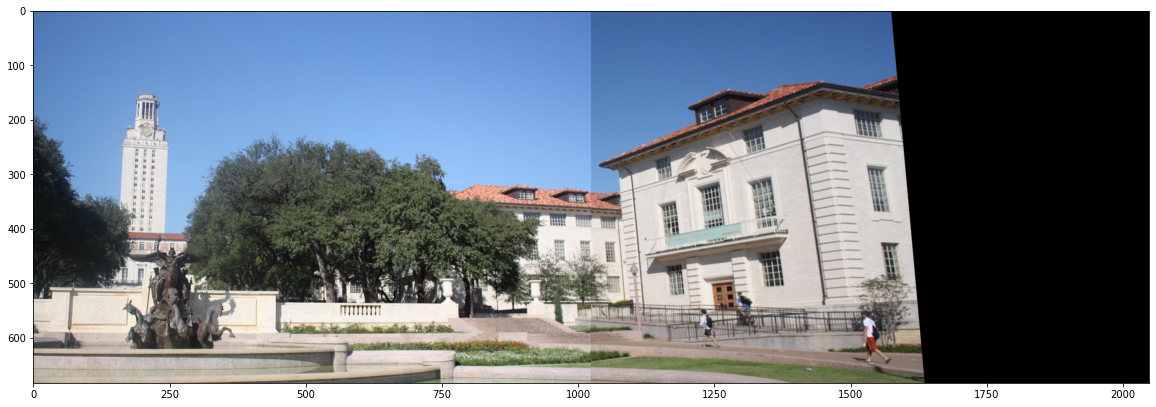

In [ ]:
h1, w1 = src_img.shape[:2]
h2, w2 = tar_img.shape[:2]

result = cv2.warpPerspective(src_img, H, (w1+w2, h1))
result[0:h2, 0:w2] = tar_img

plot_img(result, size=(20,10))